In [1]:
import string
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import Levenshtein
from nltk.util import ngrams
from nltk.corpus import stopwords
from wordcloud import WordCloud

warnings.filterwarnings('ignore')

%matplotlib inline

plt.style.use('default')

sns.set(style='whitegrid')

In [2]:
df = pd.read_csv('data/no-third-party-conversions.csv', low_memory=False)

# Análisis de términos de búsqueda

En este notebook, vamos a analizar los términos de búsqueda ingresados por los usuarios del sitio de la empresa.

Antes de realizar cualquier tipo de observación, será necesario limpiar los datos un poco, ya que los errores ortográficos son moneda corriente, y podrían llegar a distorsionar lo que haremos más adelante.

## Corrección de errores comunes.

Nos ocuparemos de los errores comunes utilizando la distancia de Levenshtein como métrica para determinar cuándo estamos ante un error común.

La distancia de Levenshtein se entiende como el número mínimo de operaciones que se deben realizar sobre una cadena para transformarla en otra. La misma se presenta como un valor entre 0 y 1, por lo que consideraremos que aquellas palabras que presenten un valor mayor o igual a 0.7 serán tomadas como un error y las corregiremos.

Por supuesto esto presenta algunos problemas, como en el caso de palabras como `celular` y `celulares`, ya que si bien son distintas, una de ellas será considerada errónea y por lo tanto se modificará, por lo cual las excluiremos de la lista de errores comunes y sólo nos quedaremos con los nombres de celulares/marcas.

Además quitaremos caracteres especiales ya que también podrían ser parte de los errores pres

In [3]:
errores_comunes = ['samsung', 'galaxy', 'iphone', 'apple', 'sony', 'plus']

def corregir_errores_comunes(frase):
    palabras = frase.split(' ')
    for palabra in palabras:
        for clave in errores_comunes:
            if Levenshtein.ratio(clave, palabra) >= 0.7:
                palabras[palabras.index(palabra)] = clave
                break
    return ' '.join(palabras)

In [4]:
terminos_busqueda = df.loc[df['search_term'].notnull(), ['timestamp', 'person', 'event', 'search_term', 'skus']]
terminos_busqueda['timestamp'] = pd.to_datetime(terminos_busqueda['timestamp'])
terminos_busqueda['search_term'] = terminos_busqueda['search_term'].apply(lambda x: x.lower())
terminos_busqueda['search_term'] = terminos_busqueda['search_term'].str.replace('[{}]'.format(string.punctuation), '')
terminos_busqueda['search_term'] = terminos_busqueda['search_term'].apply(lambda x: corregir_errores_comunes(x))

## Visualizando la frecuencia de los términos de búsqueda.

Ahora que terminamos con la breve limpieza de los términos de búsqueda, utilizaremos dos visualizaciones para ver las frecuencias de los mismos.

En primer lugar, un Wordcloud para tener una idea rápida de cuáles son los términos más frecuentes.

Luego utilizaremos un gráfico de barras para visualizar los diez términos más frecuentes.

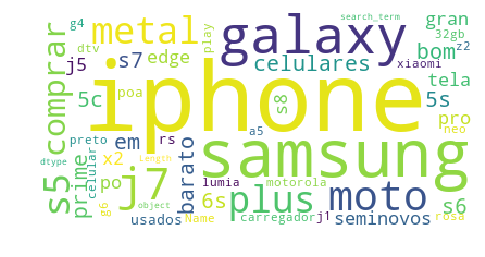

In [5]:
wordcloud = WordCloud(background_color='white',
                      max_words=200
                     ).generate(str(terminos_busqueda['search_term']))
plt.figure(figsize=[14,4])
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

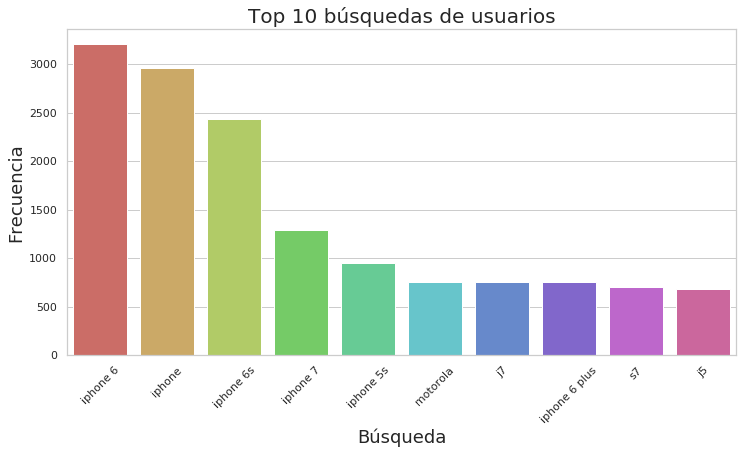

In [6]:
barplot_st = terminos_busqueda['search_term'].value_counts().head(10)
plt.figure(figsize=[12,6])
g = sns.barplot(x=barplot_st.index, y=barplot_st.values, palette='hls')
g.set_title('Top 10 búsquedas de usuarios', fontsize=20)
g.set_xlabel('Búsqueda', fontsize=18)
g.set_ylabel('Frecuencia', fontsize=18)
plt.xticks(rotation=45)
plt.show()

## Relevancia del término de búsqueda para los resultados devueltos por el buscador de la página.

Al ver que contabamos con la información relacionada a las búsquedas realizadas por los usuarios, surgió la idea de intentar medir qué tan relevante son los resultados devueltos por el buscador, para los términos de búsqueda más usados por los usuarios del sitio.

Por supuesto se puede asumir que el buscador del sitio funciona correctamente, pero de todas formas creemos que puede ser un análisis interesante.

Para esto utilizaremos una métrica conocida como `term frequency` la cual recompensa o adjudica mayor relevancia a aquellos términos que aparecen con mayor frecuencia en un texto.

A diferencia del análisis de palabras claves en textos dentro de un conjunto de textos, donde se utiliza la métrica `inverse document frequency` en conjunto a `term frequency` para premiar a aquellas palabras que además de ser frecuentes, también son _raras_, aquí sólo nos interesa qué tan frecuentemente aparecen estos términos en los resultados de las búsquedas.

En nuestro caso utilizaremos los resultados de cada búsqueda, y haremos un promedio de la frecuencia con la que aparece el término utilizado para obtener dichos resultados, de esta forma asignaremos los puntajes a cada uno de los términos de búsqueda.

Primero obtendremos las características asociadas a cada SKU, ya que el resultado de una búsqueda es un listado de SKUs.

Esto lo pasaremos a un diccionario para luego transformar ese listado de SKUs en cadenas con las características del modelo asociado.

In [7]:
skus = df.loc[~df['sku'].isnull(), ['sku', 'model', 'condition', 'storage', 'color']].drop_duplicates(subset='sku')
skus['sku'] = skus['sku'].apply(lambda x: str(x[:-2]))
skus.set_index('sku', inplace=True)
skus = skus.apply(lambda x: x.str.lower(), axis=1)
skus.head()

,model,condition,storage,color
sku,,,,
2694,iphone 5s,bom,32gb,cinza espacial
15338,samsung galaxy s8,bom,64gb,dourado
12661,motorola moto z play,muito bom,32gb,preto
10254,iphone 7 plus,excelente,256gb,dourado
6581,iphone 6s,bom,16gb,cinza espacial


In [8]:
caracteristicas_segun_sku = skus.T.to_dict(orient='list')

def skus_a_caracteristicas(skus):
    skus_separados = str(skus).split(',')
    res = [' '.join(caracteristicas_segun_sku.get(x, 'Desconocido')) for x in skus_separados]
    return ' '.join(res)

Ahora filtraremos aquellos términos que no tengan un listado de SKUs asociado y agregaremos una columna con las características de cada SKU devuelto por el buscador.

In [9]:
terminos_busqueda_sin_nulls = terminos_busqueda.dropna(subset=['skus'])
terminos_busqueda_sin_nulls['resultados_busqueda'] = terminos_busqueda_sin_nulls['skus'].apply(skus_a_caracteristicas)
terminos_busqueda_sin_nulls.head()

,timestamp,person,event,search_term,skus,resultados_busqueda
127,2018-05-21 19:56:33,0024ad28,searched products,comprar celulares usados bom e barato em poa rs,"3371,6357,6371,10896,2718,2777,6001,2694,3191,...",samsung galaxy s6 flat bom 32gb dourado samsun...
128,2018-05-21 19:57:28,0024ad28,searched products,comprar celulares seminovos bom e barato em po...,"3371,6357,6371,10896,2718,2777,6001,2694,3191,...",samsung galaxy s6 flat bom 32gb dourado samsun...
129,2018-05-21 19:57:49,0024ad28,searched products,comprar celulares seminovos bom e barato em po...,"3371,6357,6371,10896,2718,2777,6001,2694,3191,...",samsung galaxy s6 flat bom 32gb dourado samsun...
177,2018-06-14 19:27:33,0026fd72,searched products,samsung galaxy s7,"8541,8527,9230,8555,8513,8485,8471,8443,8499",samsung galaxy s7 edge bom 32gb dourado samsun...
246,2018-05-30 18:33:40,002932b1,searched products,iphone 6,"6001,2833,6253,6002,2832,2837,2836,2835,2834,1...",iphone 6 bom - sem touch id 16gb cinza espacia...


Finalmente preparemos la columna `resultados_busqueda` para ser procesada en el cálculo de `td-idf`.

In [10]:
terminos_busqueda_sin_nulls = terminos_busqueda_sin_nulls.groupby('search_term')\
                            .agg({'resultados_busqueda':'-'.join, 'event':'count'})\
                            .reset_index()\
                            .rename(columns={'event':'frecuencia'})
terminos_busqueda_sin_nulls.head()

,search_term,resultados_busqueda,frecuencia
0,,samsung galaxy s6 flat bom 32gb dourado samsun...,1
1,galaxy j7 prime,samsung galaxy j7 prime excelente 32gb rosa sa...,1
2,1 carregador alternativo,samsung galaxy s6 flat bom 32gb dourado samsun...,1
3,100,samsung galaxy s7 bom 32gb dourado samsung gal...,5
4,1020,samsung galaxy s7 bom 32gb dourado samsung gal...,1


In [11]:
# Esto creo que vuela porque no tiene mucho sentido usarlo, por ahora lo dejo por las dudas.

def calcular_tfidf(fila):
    # Sumamos uno al denominador en las divisiones por las dudas.
    res = 0
    keyword_freq = 0
    keyword = fila[0]
    search_results = fila[1].split('-')
    for elem in search_results:
        if (keyword in elem):
            keyword_freq += 1
    idf = np.log((len(search_results) * 1.0) / (keyword_freq + 1))
    for elem in search_results:
        tf = (elem.count(keyword) * 1.0 ) / len(elem.split(' '))
        res += tf*idf
    return res / (len(search_results))

In [12]:
def calcular_tf(fila):
    res = 0
    keyword = fila[0]
    search_results = fila[1].split('-')
    for elem in search_results:
        tf = (elem.count(keyword) * 1.0 ) / len(elem.split(' '))
        res += tf
    return res / (len(search_results))

In [13]:
top_100_terminos = terminos_busqueda_sin_nulls.sort_values(by='frecuencia', ascending=False).head(100)
top_100_terminos['tf_score'] = top_100_terminos.apply(lambda x: calcular_tf(x), axis=1)

In [14]:
top_100_terminos.sort_values(by='tf_score', ascending=False, inplace=True)

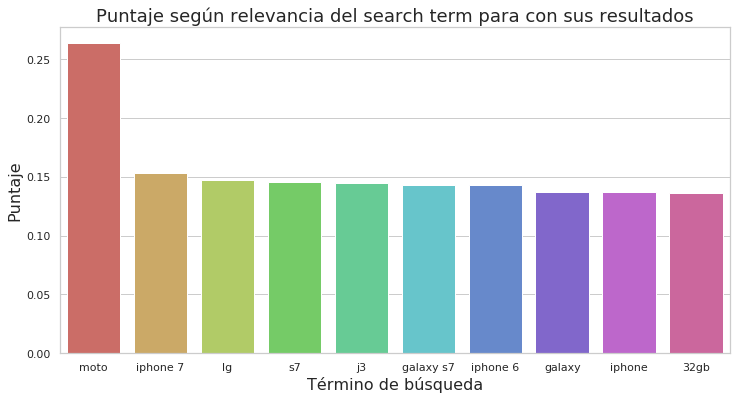

In [15]:
bp_terminos = top_100_terminos.head(10)
plt.figure(figsize=[12,6])
g = sns.barplot(data=bp_terminos, x='search_term', y='tf_score', palette='hls')
g.set_title('Puntaje según relevancia del search term para con sus resultados', fontsize=18)
g.set_xlabel('Término de búsqueda', fontsize=16)
g.set_ylabel('Puntaje', fontsize=16)
plt.show()

# Otro enfoque para analizar los términos de búsqueda

Si bien los términos de búsqueda son un punto de interés para nuestro análisis, creemos que se puede analizar de otra forma. En particular, podríamos analizar la frecuencia de n-gramas en estas búsquedas, para agrupar mejor las mismas.

### ¿Cuál es la motivación de este enfoque? 

Puesto que estamos analizando el input consumido por el search engine del sitio de la empresa, tal vez podamos encontrar algo interesante, como nuevas keywords para los productos ofrecidos en el sitio.

### ¿Cómo vamos a realizar este análisis?

En primer lugar, debemos filtrar las _stopwords_ del lenguaje que presenta mayoría (en este caso, portugués). El fin de esto es prevenir que aparezcan en nuestros reportes palabras de uso común pero que carecen de contenido, como por ejemplo `por`, `de`, `mais`.

Luego utilizaremos la biblioteca `nltk` para poder procesar cada término de búsqueda y extraer los n-gramas que nos interesen.

Finalmente presentaremos la información por medio de gráficos de barra, ya que nos interesa ver los n-gramas que presenten mayor frecuencia.

In [16]:
terminos_sin_filtrar = terminos_busqueda['search_term'].tolist()

errores_comunes = ['samsung', 'galaxy', 'iphone', 'sony', 'celular', 'plus', 'barato', 'usado']
## Vamos a cachear las stopwords ya que queremos evitar un cuello de botella al cargarlo constantemente.
cached_stopwords = stopwords.words('portuguese')

terminos_filtrados = []

for frase in terminos_sin_filtrar:
    terminos_filtrados.append(' '.join([palabra for palabra in frase.split(' ') if palabra not in cached_stopwords]))

In [17]:
def obtener_ngramas(frases, n):
    data = []
    for frase in frases:
        tokens = [token for token in frase.split(" ") if token != ""]
        ngramas = list(ngrams(tokens, n))
        for _ in ngramas:
            data.append(_)
    res = [(lambda x: ' '.join(x))(x) for x in data]
    return res

## Unigramas

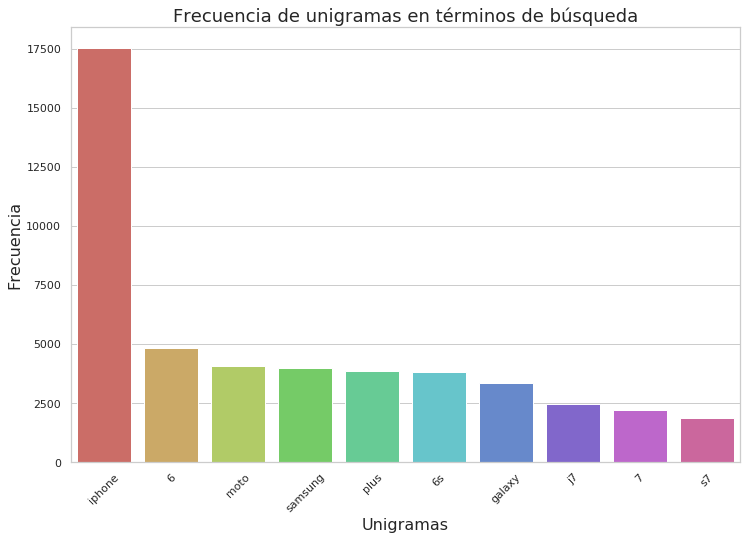

In [18]:
unigrams = obtener_ngramas(terminos_filtrados, 1)
serie = pd.Series(x for x in unigrams).value_counts().head(10)
plt.figure(figsize=[12,8])
g = sns.barplot(x=serie.index, y=serie.values, palette='hls')
g.set_title('Frecuencia de unigramas en términos de búsqueda', fontsize=18)
g.set_xlabel('Unigramas', fontsize=16)
g.set_ylabel('Frecuencia', fontsize=16)
plt.xticks(rotation=45)
plt.show()

## 2-gramas

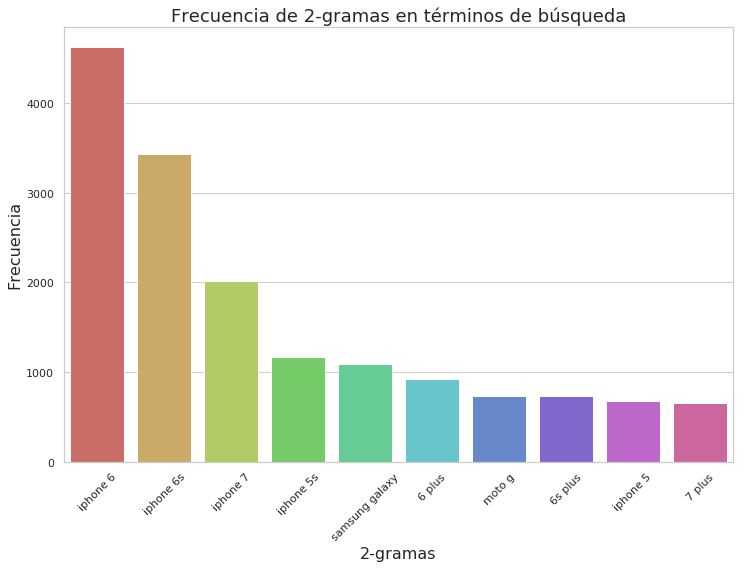

In [19]:
bigrams = obtener_ngramas(terminos_filtrados, 2)
serie = pd.Series(x for x in bigrams).value_counts().head(10)
plt.figure(figsize=[12,8])
g = sns.barplot(x=serie.index, y=serie.values, palette='hls')
g.set_title('Frecuencia de 2-gramas en términos de búsqueda', fontsize=18)
g.set_xlabel('2-gramas', fontsize=16)
g.set_ylabel('Frecuencia', fontsize=16)
plt.xticks(rotation=45)
plt.show()

## 3-gramas

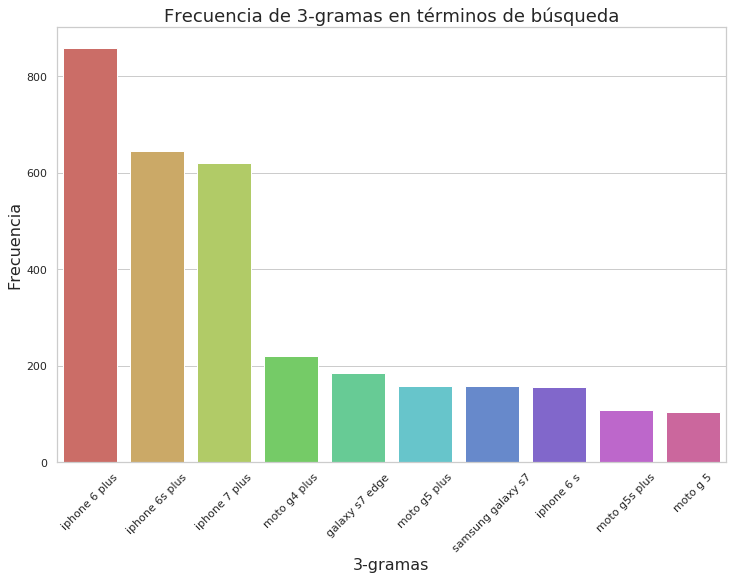

In [20]:
trigrams = obtener_ngramas(terminos_filtrados, 3)
serie = pd.Series(x for x in trigrams).value_counts().head(10)
plt.figure(figsize=[12,8])
g = sns.barplot(x=serie.index, y=serie.values, palette='hls')
g.set_title('Frecuencia de 3-gramas en términos de búsqueda', fontsize=18)
g.set_xlabel('3-gramas', fontsize=16)
g.set_ylabel('Frecuencia', fontsize=16)
plt.xticks(rotation=45)
plt.show()

## Puntaje de cada n-grama

Si bien sabemos que contamos con un subset del dataset completo, y no sabemos si el mismo es representativo de su _progenitor_, intentaremos puntuar a cada n-grama según las conversiones que se realizaron a partir de su aparición en un término de búsqueda.

Además tampoco es posible realizar una reconstrucción certera del _funnel_ por el cual el usuario llega a realizar una conversión, sólo se puede aproximar. 

Analizaremos bigramas y trigramas en particular.

TODO: Profundizar un poco más esta explicación ya que no está ni mencionado cómo se van a puntuar los n-gramas.

In [21]:
def obtener_freq_conversiones(ngram):
    """
    ### TODO: Falta filtrar por un delta de tiempo prudente.

    usuarios_conversiones = set(df.loc[(df['event'] == 'conversion') & (df['person'].isin(usuarios)), 'person'])

    presentan_conversiones = df.loc[((df['event'] == 'conversion') & (df['person'].isin(usuarios))) |\
                                   ((df['event'] == 'searched products') & (df['search_term'].str.contains(bigram)) &\
                                   (df['person'].isin(usuarios_conversiones)))
                                   , ['timestamp', 'event', 'search_term', 'person', 'model', 'sku', 'skus']]
    """

    busquedas_filtradas = df.loc[(df['event'] == 'searched products') & (df['search_term'].str.contains(ngram)), 'person']

    usuarios = set(busquedas_filtradas)

    res = df.loc[((df['event'] == 'conversion') & (df['person'].isin(usuarios))), 'model']
    # Descartamos aquellos valores que estén muy lejos del ngram, según distancia de Levenshtein.
    return res.apply(lambda x: x if Levenshtein.ratio(x.lower(), ngram) > 0.5 else None).dropna().size

## Puntaje para cada  bigrama

In [22]:
conversiones_bigramas = pd.Series(x for x in bigrams).value_counts().to_frame().reset_index()
conversiones_bigramas.rename(columns={'index':'bigrama', 0:'freq'}, inplace=True)

In [23]:
# Si bien el grado de dispersión es altísimo, tomaremos los 100 primeros elementos para asignar puntajes.
conversiones_bigramas['conversiones'] = conversiones_bigramas['bigrama'].head(100)\
.apply(lambda x: obtener_freq_conversiones(x))
conversiones_bigramas['puntaje'] = conversiones_bigramas['conversiones'] / conversiones_bigramas['freq'] * 100
conversiones_bigramas.sort_values(by='puntaje', ascending=False).head(10)

,bigrama,freq,conversiones,puntaje
69,s plus,88,6.0,6.818182
45,galaxy s5,155,2.0,1.290323
33,motorola moto,202,2.0,0.990099
7,6s plus,727,6.0,0.825309
53,iphone 4,130,1.0,0.769231
13,galaxy s7,557,4.0,0.718133
22,galaxy s6,312,2.0,0.641026
8,iphone 5,679,4.0,0.589102
4,samsung galaxy,1088,6.0,0.551471
16,iphone 8,397,2.0,0.503778


In [24]:
conversiones_bigramas.describe()

,freq,conversiones,puntaje
count,2650.000000,100.000000,100.000000
mean,15.766792,0.640000,0.162017
std,132.198879,1.708683,0.713053
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000
75%,4.000000,0.000000,0.000000
max,4619.000000,11.000000,6.818182


## Puntaje para cada trigrama

In [25]:
conversiones_trigramas = pd.Series(x for x in trigrams).value_counts().to_frame().reset_index()
conversiones_trigramas.rename(columns={'index':'trigrama', 0:'freq'}, inplace=True)

In [26]:
# Acá nos pasa lo mismo con el grado de dispersión, así que calcularemos puntajes por diversión.
conversiones_trigramas['conversiones'] = conversiones_trigramas['trigrama'].head(100)\
.apply(lambda x: obtener_freq_conversiones(x))
conversiones_trigramas['puntaje'] = conversiones_trigramas['conversiones'] / conversiones_trigramas['freq'] * 100
conversiones_trigramas.sort_values(by='puntaje', ascending=False).head(10)

,trigrama,freq,conversiones,puntaje
45,iphone 6 16gb,38,2.0,5.263158
27,samsung galaxy s5,58,3.0,5.172414
87,motorola moto g2,20,1.0,5.000000
93,moto g4 dtv,20,1.0,5.000000
54,motorola moto g4,32,1.0,3.125000
19,samsung galaxy s6,67,2.0,2.985075
38,moto x play,44,1.0,2.272727
4,galaxy s7 edge,184,1.0,0.543478
2,iphone 7 plus,620,3.0,0.483871
3,moto g4 plus,221,1.0,0.452489


In [27]:
conversiones_trigramas.describe()

,freq,conversiones,puntaje
count,2060.000000,100.00000,100.000000
mean,5.795146,0.17000,0.304530
std,29.942178,0.55149,1.099957
min,1.000000,0.00000,0.000000
25%,1.000000,0.00000,0.000000
50%,2.000000,0.00000,0.000000
75%,3.000000,0.00000,0.000000
max,859.000000,3.00000,5.263158
